#  EDA and Feature engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
train = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/train.csv', parse_dates=['Date'])
stores = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/stores.csv')
features = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/features.csv', parse_dates=['Date'])

# --- Merge data ---
df = train.merge(stores, on='Store', how='left')
df = df.merge(features, on=['Store', 'Date'], how='left')

#df.to_csv('Ntrain.csv', index=False)

In [2]:
# --- Drop duplicates ---
df.drop_duplicates(inplace=True)

# --- Handle missing values ---
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# CPI and Unemployment forward filled per Store
df.sort_values(['Store', 'Date'], inplace=True)
df[['CPI', 'Unemployment']] = df.groupby('Store')[['CPI', 'Unemployment']].ffill()

# Backfill remaining missing values
df['CPI'] = df['CPI'].bfill()
df['Unemployment'] = df['Unemployment'].bfill()



if 'IsHoliday_x' in df.columns:
    df.drop('IsHoliday_x', axis=1, inplace=True)


# Rename 'IsHoliday_y' to 'IsHoliday'
df.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)


# --- Feature Engineering ---
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day

# --- Encode categorical ---
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])


# For Better Table View 
exclude = {'MarkDown2', 'MarkDown3', 'MarkDown4'}
cols_to_show = [col for col in df.columns if col not in exclude]
print(tabulate(df[cols_to_show].tail(10), headers='keys', tablefmt='psql', showindex=False))
print(df.columns.tolist())

+---------+--------+---------------------+----------------+--------+--------+---------------+--------------+-------------+-------------+---------+----------------+-------------+--------+---------+--------+-------+
|   Store |   Dept | Date                |   Weekly_Sales |   Type |   Size |   Temperature |   Fuel_Price |   MarkDown1 |   MarkDown5 |     CPI |   Unemployment | IsHoliday   |   Year |   Month |   Week |   Day |
|---------+--------+---------------------+----------------+--------+--------+---------------+--------------+-------------+-------------+---------+----------------+-------------+--------+---------+--------+-------|
|      45 |     85 | 2012-10-26 00:00:00 |        1689.1  |      1 | 118221 |         58.85 |        3.882 |     4018.91 |      858.33 | 192.309 |          8.667 | False       |   2012 |      10 |     43 |    26 |
|      45 |     87 | 2012-10-26 00:00:00 |        8187.66 |      1 | 118221 |         58.85 |        3.882 |     4018.91 |      858.33 | 192.309

# Visulization to Undestand Dataset

# Total Weekly Sales Over Time (Trend + Seasonality Insight)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


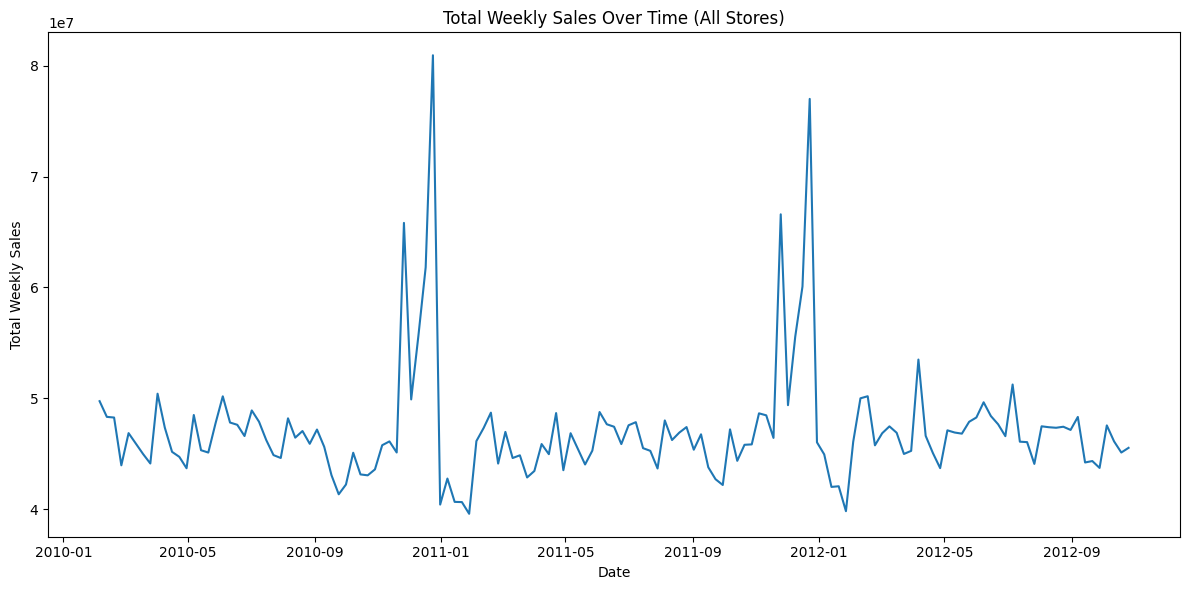

In [3]:
sales_time = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=sales_time, x='Date', y='Weekly_Sales')
plt.title('Total Weekly Sales Over Time (All Stores)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.tight_layout()
plt.show()

> Sales show strong seasonal patterns with spikes during major holidays like Thanksgiving and Christmas, reflecting shopper behavior and marketing impact>

# Seasonal Decomposition of Weekly Sales

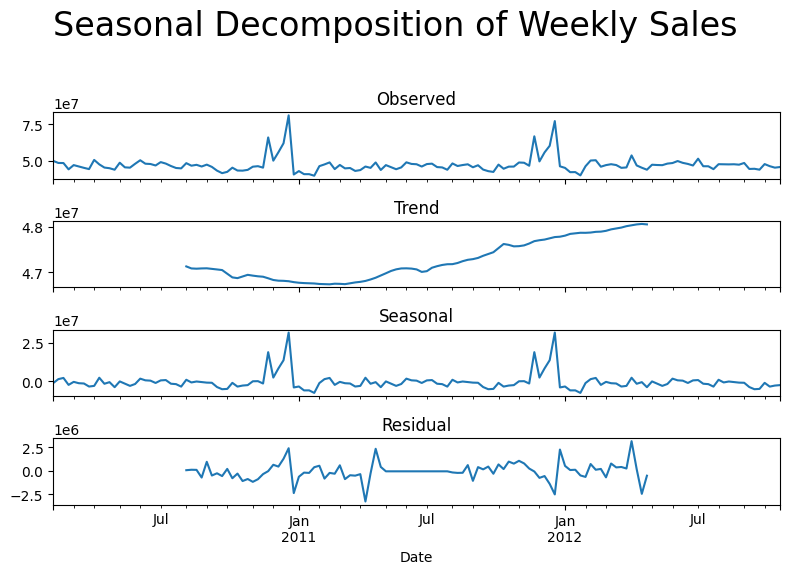

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Group weekly sales by date
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()

# Perform seasonal decomposition
decomp = seasonal_decompose(weekly_sales, model='additive', period=52)

# Manually create a wider figure
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Plot each component on its own axis
decomp.observed.plot(ax=axes[0], title='Observed')
decomp.trend.plot(ax=axes[1], title='Trend')
decomp.seasonal.plot(ax=axes[2], title='Seasonal')
decomp.resid.plot(ax=axes[3], title='Residual')

# Add overall title and layout adjustments
fig.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the suptitle
plt.show()

> Decomposition reveals a clear upward trend over years and strong seasonal spikes annually, crucial for forecasting and inventory planning

# Sales Distribution by Store Type

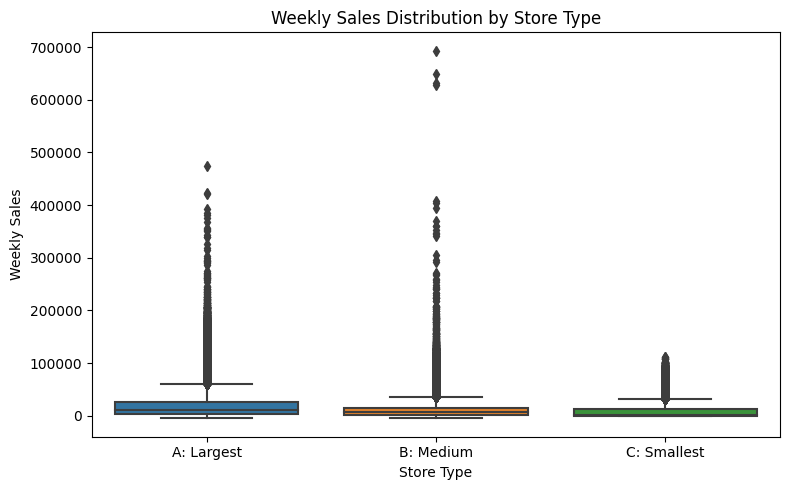

In [5]:
# Map encoded Type back to labels for clear plotting
type_map = {0: 'A: Largest', 1: 'B: Medium', 2: 'C: Smallest'}
df['Type_label'] = df['Type'].map(type_map)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Type_label', y='Weekly_Sales')
plt.title('Weekly Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

> Largest stores (Type A) show higher and more consistent weekly sales, while smaller stores (Type C) have wider variation and lower median sales.

# Average Sales: Holiday vs Non-Holiday

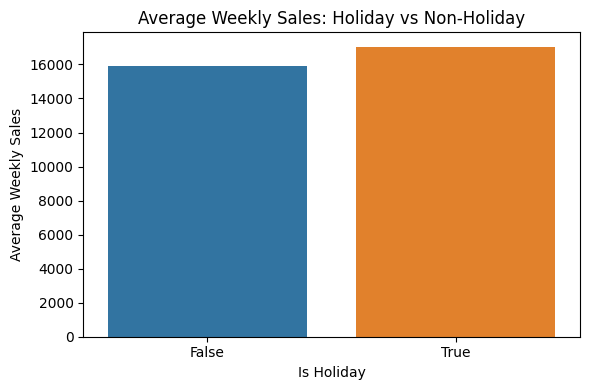

In [6]:
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=holiday_sales, x='IsHoliday', y='Weekly_Sales')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.tight_layout()
plt.show()

> Average sales increase significantly during holiday weeks across all stores, reflecting consumer spending spikes

# Markdown1 vs Weekly Sales (Sampled Scatterplot)

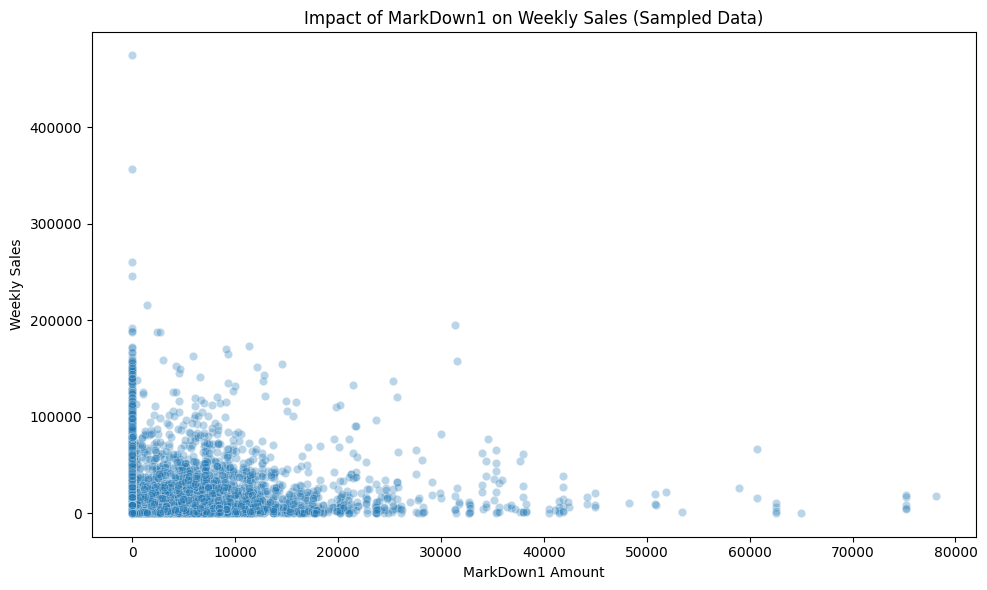

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='MarkDown1', y='Weekly_Sales', data=df.sample(10000, random_state=42), alpha=0.3)
plt.title('Impact of MarkDown1 on Weekly Sales (Sampled Data)')
plt.xlabel('MarkDown1 Amount')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

> Higher markdown amounts generally correlate with increased sales, indicating markdowns effectively boost customer purchases

# Top 10 Departments by Total Sales

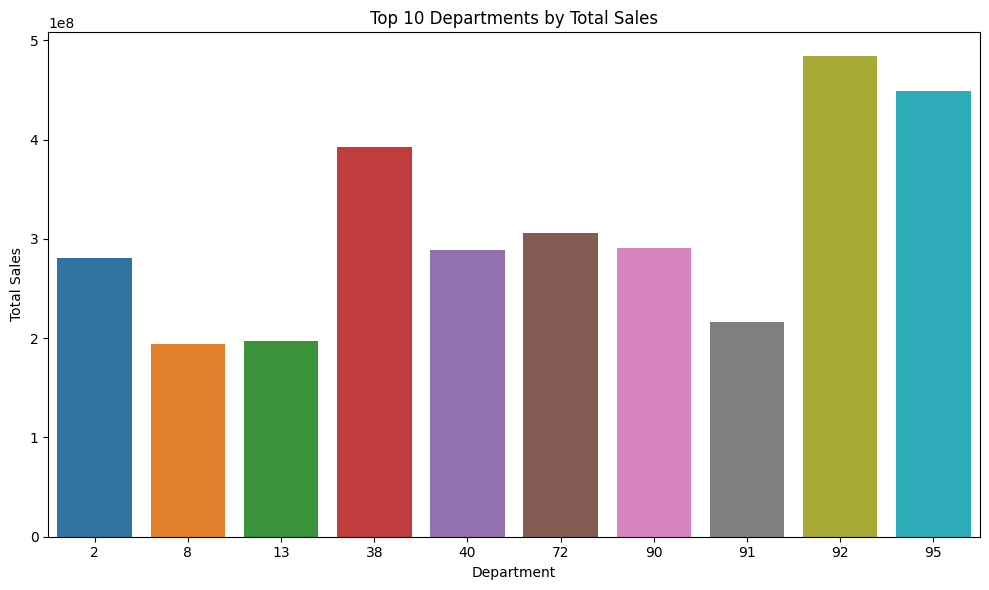

In [8]:
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_depts, x='Dept', y='Weekly_Sales')
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

> Departments 92, 95, and 38 dominate total sales, likely representing popular product categories.

# Holiday vs Non-Holiday Sales Trend by Store Type

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


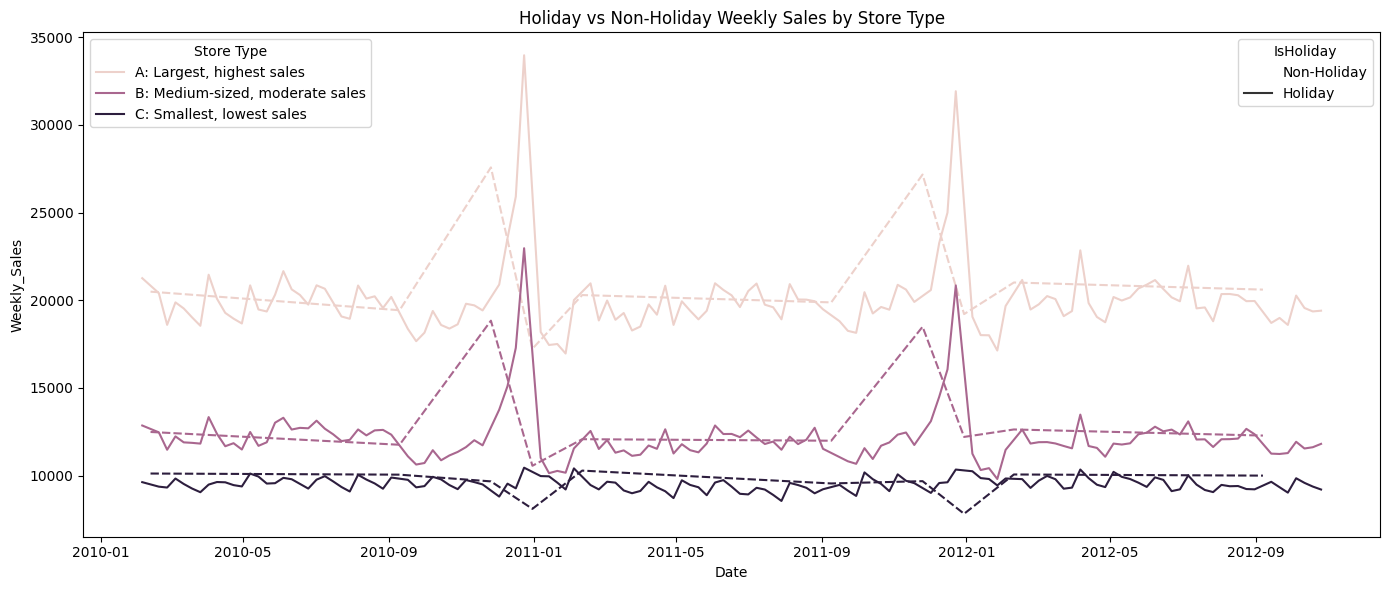

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

holiday_trend = df.groupby(['Date', 'Type', 'IsHoliday'])['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(14,6))
ax = sns.lineplot(data=holiday_trend, x='Date', y='Weekly_Sales', hue='Type', style='IsHoliday')

ax.set_title('Holiday vs Non-Holiday Weekly Sales by Store Type')

# Define concise labels for Types
type_labels = [
    'A: Largest, highest sales',
    'B: Medium-sized, moderate sales',
    'C: Smallest, lowest sales'
]

# Extract current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Separate handles for Type and IsHoliday
type_handles = handles[1:4]
style_handles = handles[4:6]

# Create combined legend
from matplotlib.legend import Legend

# Remove existing legend first
ax.legend_.remove()

# Add Type legend
legend1 = ax.legend(type_handles, type_labels, title='Store Type', loc='upper left')

# Add IsHoliday legend
legend2 = plt.legend(style_handles, ['Non-Holiday', 'Holiday'], title='IsHoliday', loc='upper right')

# Add both legends manually
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

> Holiday weeks consistently boost sales across all store types, with largest stores (Type A) showing highest baseline sales

In [10]:
# 1. Holiday vs Non-Holiday Sales Increase
holiday_sales = df[df['IsHoliday'] == True]['Weekly_Sales'].mean()
non_holiday_sales = df[df['IsHoliday'] == False]['Weekly_Sales'].mean()
holiday_increase_pct = ((holiday_sales - non_holiday_sales) / non_holiday_sales) * 100

# 2. Store Size Impact (Median sales difference: Type A vs B & C)
median_sales_by_type = df.groupby('Type')['Weekly_Sales'].median()
large_store_sales = median_sales_by_type[0]   # Assuming 0 = 'A'
smaller_store_sales = median_sales_by_type[[1, 2]].mean()  # 1,2 = 'B','C'
store_size_diff_pct = ((large_store_sales - smaller_store_sales) / smaller_store_sales) * 100

# 3. Holiday Sales Increase by Store Type
holiday_sales_by_type = df[df['IsHoliday'] == True].groupby('Type')['Weekly_Sales'].mean()
non_holiday_sales_by_type = df[df['IsHoliday'] == False].groupby('Type')['Weekly_Sales'].mean()
holiday_increase_by_type_pct = ((holiday_sales_by_type - non_holiday_sales_by_type) / non_holiday_sales_by_type) * 100

# 4. Markdown1 Impact on Sales
markdown_sales = df[df['MarkDown1'] > 0]['Weekly_Sales'].mean()
no_markdown_sales = df[df['MarkDown1'] == 0]['Weekly_Sales'].mean()
markdown_uplift_pct = ((markdown_sales - no_markdown_sales) / no_markdown_sales) * 100

# 5. Top 10 Departments Contribution to Total Sales
total_sales = df['Weekly_Sales'].sum()
sales_by_dept = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
top_10_sales = sales_by_dept.head(10).sum()
top_10_contribution_pct = (top_10_sales / total_sales) * 100

# Print all results
print(f"Holiday sales increase: {holiday_increase_pct:.2f}%")
print(f"Large store vs smaller store median sales difference: {store_size_diff_pct:.2f}%")
print("Holiday sales increase by store type (%):")
print(holiday_increase_by_type_pct.round(2))
print(f"Markdown1 sales uplift: {markdown_uplift_pct:.2f}%")
print(f"Top 10 departments contribution to total sales: {top_10_contribution_pct:.2f}%")

Holiday sales increase: 7.13%
Large store vs smaller store median sales difference: 175.44%
Holiday sales increase by store type (%):
Type
0    6.44
1    9.82
2    0.15
Name: Weekly_Sales, dtype: float64
Markdown1 sales uplift: 2.30%
Top 10 departments contribution to total sales: 46.03%


# Walmart Weekly Sales — Tree-Based Forecasting Pipeline
Baselines: XGBoost, LightGBM, CatBoost
Train/test split by time; robust feature engineering; consistent evaluation.

In [11]:
# 1) Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping
from catboost import CatBoostRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2) Load & Merge

In [12]:
# Kaggle paths
train_path = '/kaggle/input/walmart-store-sales-forecasting/train.csv'
stores_path = '/kaggle/input/walmart-store-sales-forecasting/stores.csv'
features_path = '/kaggle/input/walmart-store-sales-forecasting/features.csv'

train = pd.read_csv(train_path, parse_dates=['Date'])
stores = pd.read_csv(stores_path)
features = pd.read_csv(features_path, parse_dates=['Date'])

df = train.merge(stores, on='Store', how='left').merge(features, on=['Store','Date'], how='left')

## 3) Clean & Feature Engineering

In [13]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Fill Markdowns
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for c in markdown_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Fix IsHoliday
if 'IsHoliday_x' in df.columns:
    df['IsHoliday'] = df['IsHoliday_x']
    df.drop(columns=[col for col in ['IsHoliday_x','IsHoliday_y'] if col in df.columns], inplace=True)

# Sort & fill CPI/Unemployment
df.sort_values(['Store','Date'], inplace=True)
for col in ['CPI','Unemployment']:
    if col in df.columns:
        df[col] = df.groupby('Store')[col].ffill().bfill()

# Encode Type
if df['Type'].dtype == 'O':
    le = LabelEncoder()
    df['Type'] = le.fit_transform(df['Type'])

# Time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['IsHoliday'] = df['IsHoliday'].astype(int)

## 4) Supervised Features for Tree Models (per Store,Dept)

In [14]:
TARGET = 'Weekly_Sales'
base_feats = [
    'Store','Dept','Type','IsHoliday','CPI','Unemployment',
    'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
    'Year','Month','Week','Day'
]

# Lags & Rolling
df = df.sort_values(['Store','Dept','Date'])
for lag in [1,2,3]:
    df[f'Lag_{lag}'] = df.groupby(['Store','Dept'])[TARGET].shift(lag)

df['Rolling_Mean_4'] = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(window=4).mean()
df['Rolling_Std_4']  = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(window=4).std()

tree_feats = base_feats + ['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4']
df_tree = df.dropna(subset=['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4'])

# Time-based split
CUTOFF = pd.to_datetime('2012-10-01')
train_tree = df_tree[df_tree['Date'] < CUTOFF]
test_tree  = df_tree[df_tree['Date'] >= CUTOFF]

X_train = train_tree[tree_feats]
y_train = train_tree[TARGET]
X_test  = test_tree[tree_feats]
y_test  = test_tree[TARGET]

print("Tree Train:", X_train.shape, "Tree Test:", X_test.shape)

Tree Train: (396570, 20) Tree Test: (11866, 20)


## 5) Train Gradient Boosting Models

In [15]:
def metrics(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

results = {}
pred_series = {}

# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=600, learning_rate=0.08, max_depth=7,
    subsample=0.8, colsample_bytree=0.8,
    random_state=RANDOM_STATE, tree_method='hist'
)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=30,
              verbose=False)
pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = metrics(y_test, pred_xgb)
pred_series['XGBoost'] = pd.Series(pred_xgb, index=test_tree['Date'])

# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=-1,
    subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              callbacks=[early_stopping(stopping_rounds=50)])
pred_lgb = lgb_model.predict(X_test)
results['LightGBM'] = metrics(y_test, pred_lgb)
pred_series['LightGBM'] = pd.Series(pred_lgb, index=test_tree['Date'])

# CatBoost
cat_model = CatBoostRegressor(
    iterations=1000, learning_rate=0.05, depth=8,
    random_seed=RANDOM_STATE, verbose=False, loss_function='RMSE',
    od_type='Iter', od_wait=50
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))
pred_cat = cat_model.predict(X_test)
results['CatBoost'] = metrics(y_test, pred_cat)
pred_series['CatBoost'] = pd.Series(pred_cat, index=test_tree['Date'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3283
[LightGBM] [Info] Number of data points in the train set: 396570, number of used features: 20
[LightGBM] [Info] Start training from score 16043.313581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's l2: 6.43947e+06


## 6) Metrics Summary

In [16]:
# Full numbers
pd.options.display.float_format = '{:,.4f}'.format
metrics_df = pd.DataFrame(results).T[['RMSE','MAE','R2']].sort_values('RMSE')
print("/nModel Performance Metrics:\n")
print(metrics_df)

/nModel Performance Metrics:

               RMSE        MAE     R2
CatBoost 2,408.9115 1,197.3150 0.9878
XGBoost  2,418.9536 1,201.1801 0.9877
LightGBM 2,537.6108 1,245.8446 0.9865


# Bar chart visualization showing RMSE, MAE, and R²

✅ Model Performance Metrics (2 Decimal Places):

               RMSE        MAE     R2
CatBoost 2,408.9115 1,197.3150 0.9878
XGBoost  2,418.9536 1,201.1801 0.9877
LightGBM 2,537.6108 1,245.8446 0.9865


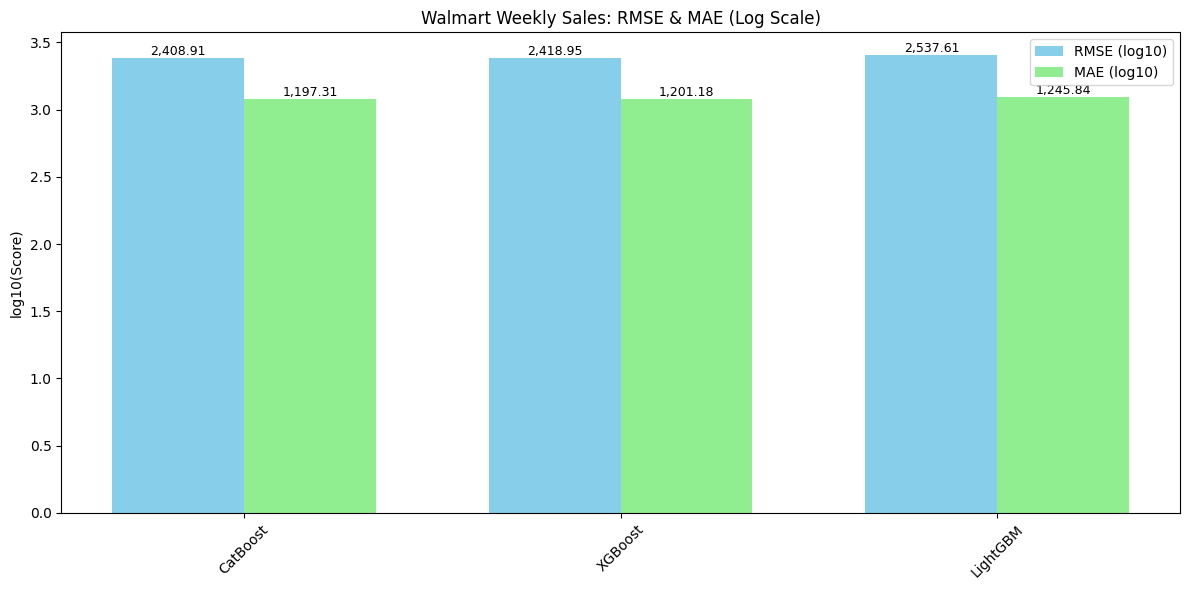

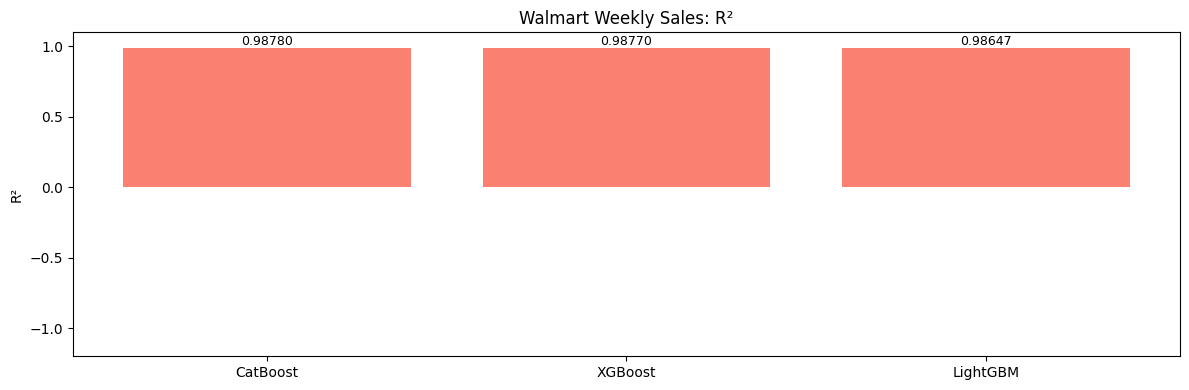

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------
# 1️⃣ Log-scale Bar Chart for RMSE & MAE
# ------------------------
plt.figure(figsize=(12,6))
bar_width = 0.35

# Full numbers with 2 decimals
pd.options.display.float_format = '{:,.4f}'.format

metrics_df = pd.DataFrame(results).T[['RMSE','MAE','R2']].sort_values('RMSE')
print("✅ Model Performance Metrics (2 Decimal Places):\n")
print(metrics_df)


x = np.arange(len(metrics_df))

bars_rmse = plt.bar(x - bar_width/2, np.log10(metrics_df['RMSE']), width=bar_width, label='RMSE (log10)', color='skyblue')
bars_mae  = plt.bar(x + bar_width/2, np.log10(metrics_df['MAE']), width=bar_width, label='MAE (log10)', color='lightgreen')

plt.xticks(x, metrics_df.index, rotation=45)
plt.ylabel('log10(Score)')
plt.title('Walmart Weekly Sales: RMSE & MAE (Log Scale)')

# Annotate bars with actual values
for bars in [bars_rmse, bars_mae]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{10**height:,.2f}', ha='center', va='bottom', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# 2️⃣ Linear Bar Chart for R2
# ------------------------
plt.figure(figsize=(12,4))
bars_r2 = plt.bar(metrics_df.index, metrics_df['R2'], color='salmon')
plt.title('Walmart Weekly Sales: R²')
plt.ylabel('R²')
plt.ylim(-1.2, 1.1)

# Annotate bars
for bar in bars_r2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.5f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

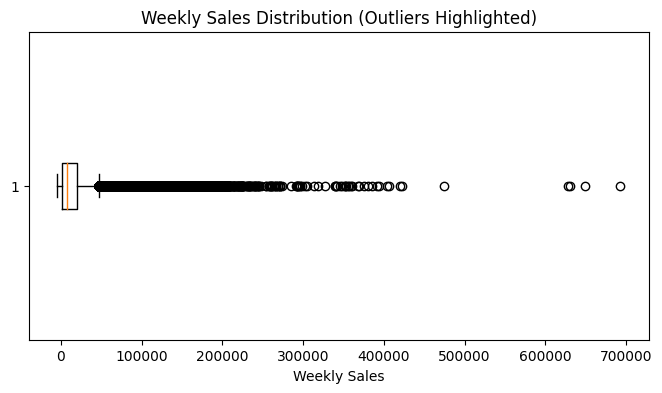

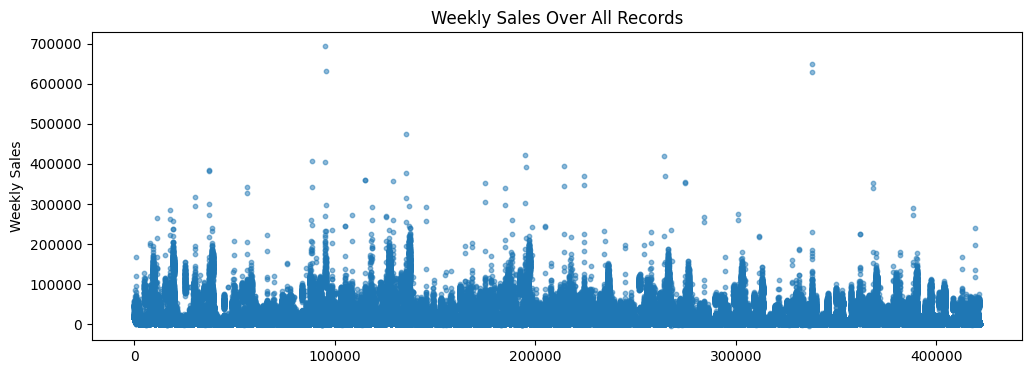

Potential Outliers:
         Store  Dept       Date  Weekly_Sales
95373      10    72 2010-11-26  693,099.3600
95425      10    72 2011-11-25  630,999.1900
337961     35    72 2010-11-26  627,962.9300
338013     35    72 2011-11-25  649,770.1800


In [18]:
import matplotlib.pyplot as plt

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df['Weekly_Sales'], vert=False)
plt.title('Weekly Sales Distribution (Outliers Highlighted)')
plt.xlabel('Weekly Sales')
plt.show()

# Scatter plot to see extreme points
plt.figure(figsize=(12,4))
plt.scatter(range(len(df)), df['Weekly_Sales'], s=10, alpha=0.5)
plt.title('Weekly Sales Over All Records')
plt.ylabel('Weekly Sales')
plt.show()

# Optional: Show the outlier rows
outliers = df[df['Weekly_Sales'] > 500_000]
print("Potential Outliers:\n", outliers[['Store','Dept','Date','Weekly_Sales']])

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# ------------------------
# 4️⃣ Lag & Rolling (per Store-Dept)
# ------------------------
TARGET = 'Weekly_Sales'
for lag in [1,2,3]:
    df[f'Lag_{lag}'] = df.groupby(['Store','Dept'])[TARGET].shift(lag)
df['Rolling_Mean_4'] = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).mean()
df['Rolling_Std_4']  = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).std()

df_tree = df.dropna(subset=['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4']).copy()

tree_feats = [
    'Store','Dept','Type','IsHoliday','Size','Temperature','Fuel_Price',
    'CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
    'Year','Month','Week','Day',
    'Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4'
]

# ------------------------
# 5️⃣ Outlier Removal Functions
# ------------------------
def remove_outliers_iqr(data):
    Q1 = data[TARGET].quantile(0.25)
    Q3 = data[TARGET].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[TARGET] >= Q1 - 1.5*IQR) & (data[TARGET] <= Q3 + 1.5*IQR)]

# ------------------------
# 6️⃣ Train/Evaluate Function
# ------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'XGB': XGBRegressor(random_state=RANDOM_STATE, n_estimators=600, learning_rate=0.08, max_depth=7, subsample=0.8, colsample_bytree=0.8, tree_method='hist'),
        'LGBM': LGBMRegressor(random_state=RANDOM_STATE, n_estimators=1000, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
        'CatBoost': CatBoostRegressor(random_seed=RANDOM_STATE, iterations=1000, learning_rate=0.05, depth=8, verbose=0)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        results[name] = {
            'RMSE': mean_squared_error(y_test, preds, squared=False),
            'MAE': mean_absolute_error(y_test, preds),
            'R2': r2_score(y_test, preds)
        }
    return results

# ------------------------
# 7️⃣ Run Scenarios
# ------------------------
scenarios = {
    'No Removal': df_tree.copy(),
    'IQR Removal': remove_outliers_iqr(df_tree.copy()),
}

all_results = {}
for scenario_name, scenario_df in scenarios.items():
    train_df = scenario_df[scenario_df['Date'] < '2012-10-01']
    test_df = scenario_df[scenario_df['Date'] >= '2012-10-01']
    
    X_train, y_train = train_df[tree_feats], train_df[TARGET]
    X_test, y_test = test_df[tree_feats], test_df[TARGET]
    
    results = train_and_evaluate(X_train, X_test, y_train, y_test)
    for model_name, metrics in results.items():
        all_results[f"{scenario_name} - {model_name}"] = metrics

metrics_df = pd.DataFrame(all_results).T[['RMSE','MAE','R2']].sort_values('RMSE')
print(metrics_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3834
[LightGBM] [Info] Number of data points in the train set: 396570, number of used features: 23
[LightGBM] [Info] Start training from score 16043.313581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 363154, number of used features: 23
[LightGBM] [Info] Start training from score 10602.382710
                             RMSE        MAE     R2
IQR Removal - CatBoost 1,510.7435   880.9128 0.9819
IQR Removal - XGB      1,511.5496   876.5331 0.9819
IQR Removal - LGBM     1,513.7397   886.8044 0.9818
No Removal - CatBoost  2,447.3501 

✅ Model Performance:
                RMSE        MAE     R2
CatBoost 2,408.9115 1,197.3150 0.9878
XGBoost  2,418.9536 1,201.1801 0.9877
LightGBM 2,495.5971 1,207.0959 0.9869


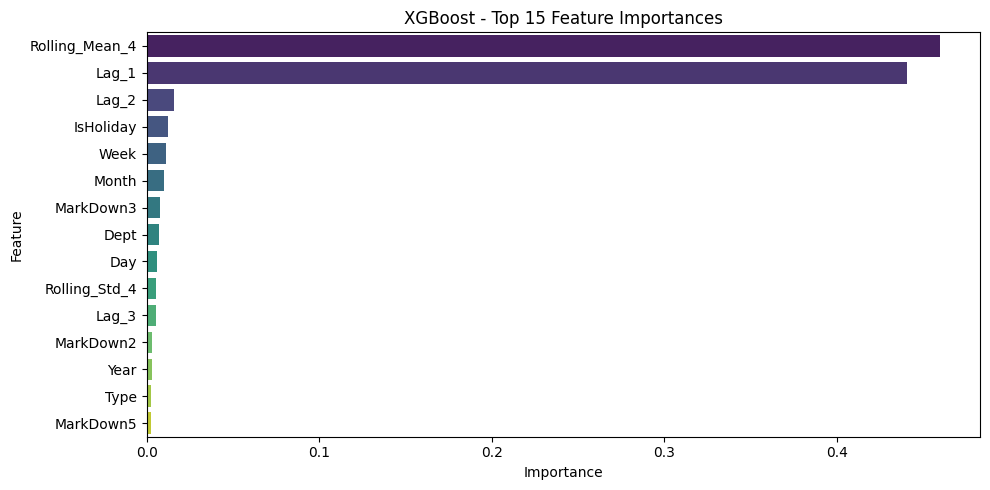

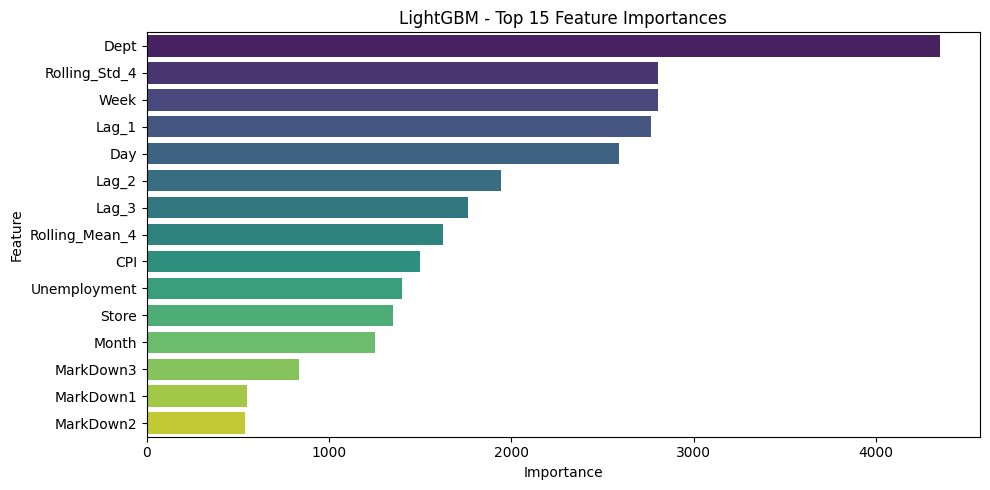

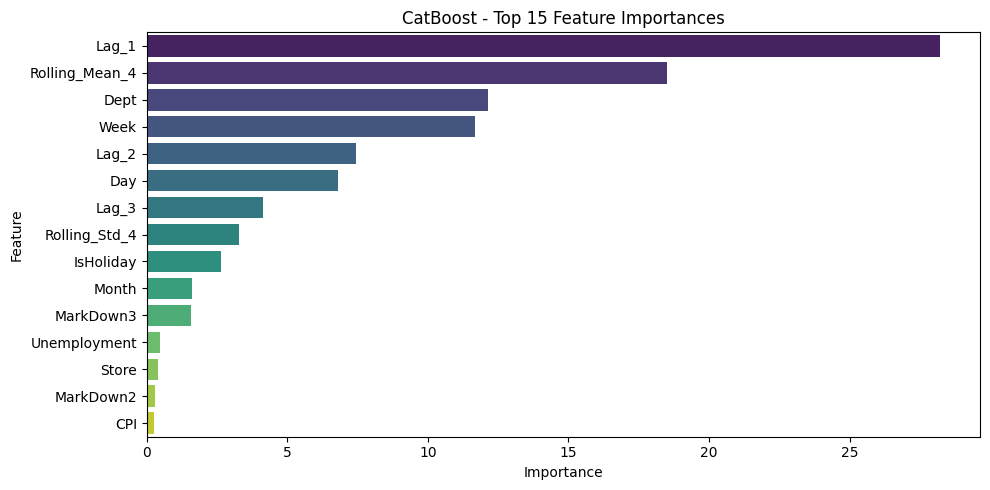

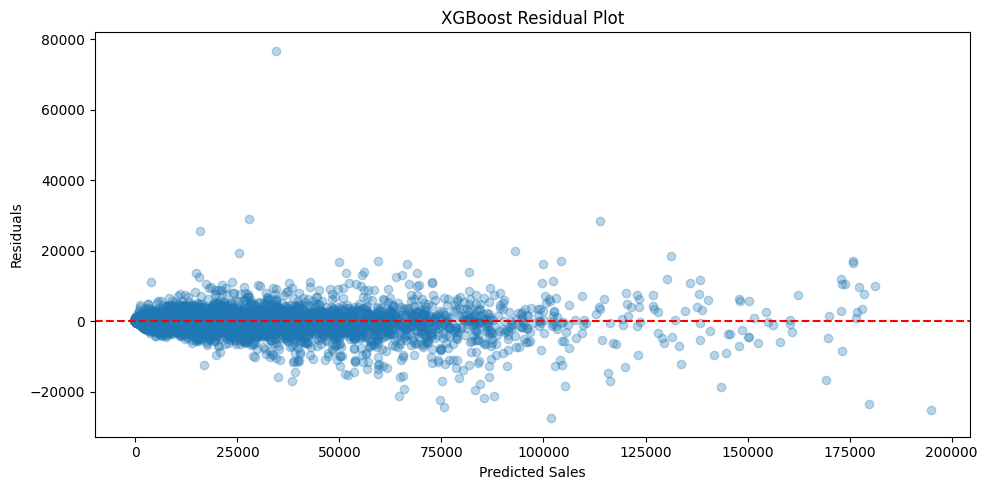

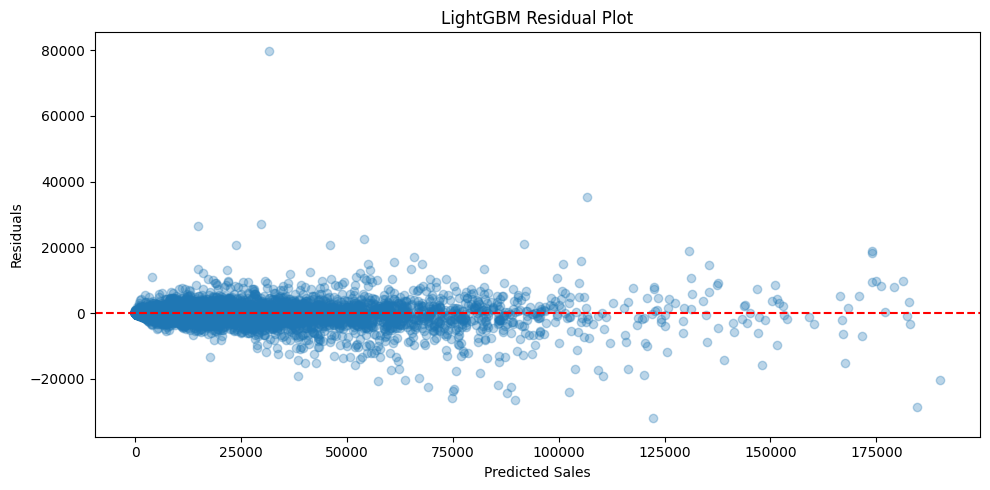

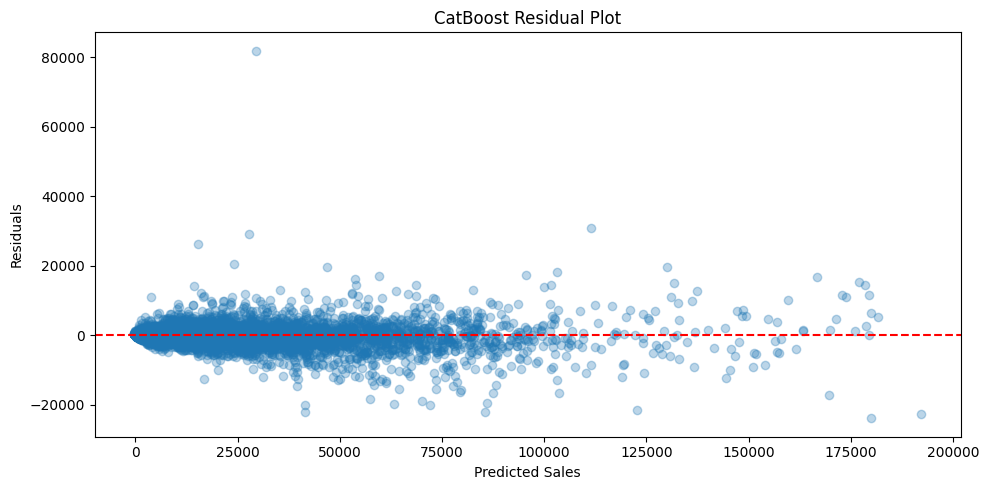


--- All Holidays Scenario ---
        Date      Actual    XGB_Pred   LGBM_Pred  CatBoost_Pred
0 2012-10-05 21,904.4700 22,873.2051 22,051.4349    20,405.3565
1 2012-10-12 22,764.0100 22,432.9922 22,594.3591    21,683.4217
2 2012-10-19 24,185.2700 25,561.1562 23,878.5189    23,586.9488
3 2012-10-26 27,390.8100 30,138.4844 26,756.5885    29,929.7105
4 2012-10-05 48,577.0800 46,386.5781 48,615.0501    45,728.3184


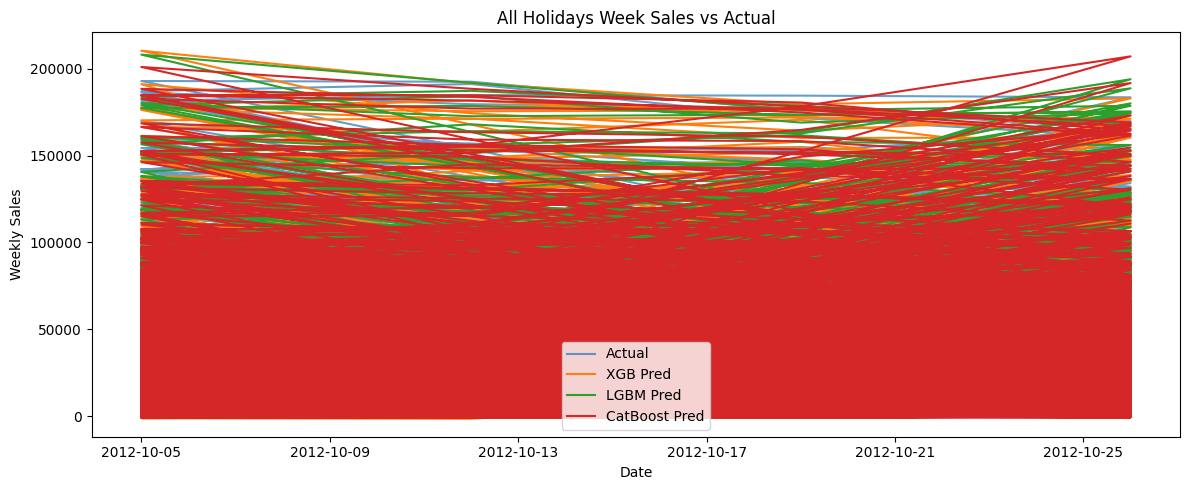


--- No Holidays Scenario ---
        Date      Actual    XGB_Pred   LGBM_Pred  CatBoost_Pred
0 2012-10-05 21,904.4700 23,135.2520 21,879.5434    20,827.2724
1 2012-10-12 22,764.0100 22,404.2949 22,634.5185    22,003.8025
2 2012-10-19 24,185.2700 25,502.8203 24,792.4705    23,542.4898
3 2012-10-26 27,390.8100 27,666.4219 26,926.6480    27,392.3678
4 2012-10-05 48,577.0800 48,535.8438 48,663.7003    47,336.1329


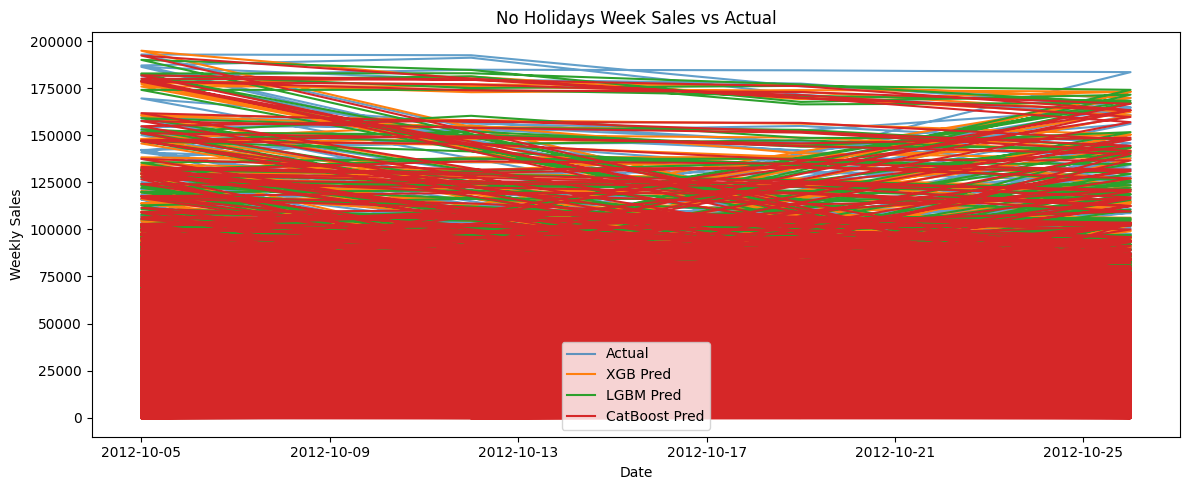

In [20]:
# ------------------------
# IMPORTS
# ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Lag & rolling features
TARGET = 'Weekly_Sales'
base_feats = ['Store','Dept','Type','IsHoliday','CPI','Unemployment',
              'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
              'Year','Month','Week','Day']

df = df.sort_values(['Store','Dept','Date'])
for lag in [1,2,3]:
    df[f'Lag_{lag}'] = df.groupby(['Store','Dept'])[TARGET].shift(lag)
df['Rolling_Mean_4'] = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).mean()
df['Rolling_Std_4'] = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).std()

tree_feats = base_feats + ['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4']
df_tree = df.dropna(subset=['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4'])

# Train/test split
CUTOFF = pd.to_datetime('2012-10-01')
train_tree = df_tree[df_tree['Date'] < CUTOFF]
test_tree  = df_tree[df_tree['Date'] >= CUTOFF]

X_train = train_tree[tree_feats]
y_train = train_tree[TARGET]
X_test  = test_tree[tree_feats]
y_test  = test_tree[TARGET]

# ------------------------
# 2️⃣ MODEL TRAINING & METRICS
# ------------------------
def metrics(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=929, learning_rate=0.08, max_depth=7,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, tree_method='hist'
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
              early_stopping_rounds=30, verbose=False)

# LightGBM
lgb_model = LGBMRegressor(
    n_estimators=1000, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbose=-1
)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

# CatBoost
cat_model = CatBoostRegressor(
    iterations=1000, learning_rate=0.05, depth=8,
    random_seed=42, verbose=0, loss_function='RMSE',
    od_type='Iter', od_wait=50
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predictions
pred_xgb = xgb_model.predict(X_test)
pred_lgb = lgb_model.predict(X_test)
pred_cat = cat_model.predict(X_test)

results = {
    'XGBoost': metrics(y_test, pred_xgb),
    'LightGBM': metrics(y_test, pred_lgb),
    'CatBoost': metrics(y_test, pred_cat)
}

metrics_df = pd.DataFrame(results).T[['RMSE','MAE','R2']].sort_values('RMSE')
print("✅ Model Performance:\n", metrics_df)

# ------------------------
# 3️⃣ FEATURE IMPORTANCE
# ------------------------
def plot_feature_importance(model, features, model_name):
    if hasattr(model, 'feature_importances_'):
        fi_df = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
        fi_df = fi_df.sort_values('Importance', ascending=False).head(15)
        plt.figure(figsize=(10,5))
        sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
        plt.title(f'{model_name} - Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()

plot_feature_importance(xgb_model, tree_feats, 'XGBoost')
plot_feature_importance(lgb_model, tree_feats, 'LightGBM')
plot_feature_importance(cat_model, tree_feats, 'CatBoost')

# ------------------------
# 4️⃣ RESIDUAL ANALYSIS
# ------------------------
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10,5))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residual Plot')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, pred_xgb, 'XGBoost')
plot_residuals(y_test, pred_lgb, 'LightGBM')
plot_residuals(y_test, pred_cat, 'CatBoost')

# ------------------------
# 5️⃣ SIMULATED AB TEST / WHAT-IF
# ------------------------
scenarios = {'All Holidays': 1, 'No Holidays': 0}

for scenario_name, holiday_val in scenarios.items():
    ab_df = test_tree.copy()
    ab_df['IsHoliday'] = holiday_val
    ab_df_clean = ab_df.dropna(subset=tree_feats)  # ensure numeric

    X_ab = ab_df_clean[tree_feats].astype(float)
    y_ab = ab_df_clean[TARGET]
    dates_ab = ab_df_clean['Date']

    pred_ab_xgb = xgb_model.predict(X_ab)
    pred_ab_lgb = lgb_model.predict(X_ab)
    pred_ab_cat = cat_model.predict(X_ab)

    comp_df = pd.DataFrame({
        'Date': dates_ab.values,
        'Actual': y_ab.values,
        'XGB_Pred': pred_ab_xgb,
        'LGBM_Pred': pred_ab_lgb,
        'CatBoost_Pred': pred_ab_cat
    })

    print(f"\n--- {scenario_name} Scenario ---")
    print(comp_df.head())

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(comp_df['Date'], comp_df['Actual'], label='Actual', alpha=0.7)
    plt.plot(comp_df['Date'], comp_df['XGB_Pred'], label='XGB Pred')
    plt.plot(comp_df['Date'], comp_df['LGBM_Pred'], label='LGBM Pred')
    plt.plot(comp_df['Date'], comp_df['CatBoost_Pred'], label='CatBoost Pred')
    plt.title(f'{scenario_name} Week Sales vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import StackingRegressor

# ------------------------
# 1️⃣ Time-based Cross-Validation
# ------------------------
tscv = TimeSeriesSplit(n_splits=5)

def cv_rmse(model, X, y):
    """Compute mean RMSE with time series CV"""
    scores = -cross_val_score(model, X, y, cv=tscv, scoring='neg_root_mean_squared_error')
    return scores.mean()

print("⏳ Running time-series CV...")

for name, model in [('XGBoost', xgb_model), ('LightGBM', lgb_model), ('CatBoost', cat_model)]:
    score = cv_rmse(model, X_train, y_train)
    print(f"{name} CV RMSE: {score:.2f}")

# ------------------------
# 2️⃣ Hyperparameter Tuning with Optuna (Example: XGBoost)
# ------------------------
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'tree_method': 'hist'
    }
    model = XGBRegressor(**param)
    score = cv_rmse(model, X_train, y_train)
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print("✅ Best hyperparameters (XGBoost):")
print(study.best_params)

# Train XGBoost with best params
xgb_best = XGBRegressor(**study.best_params)
xgb_best.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, verbose=False)

# ------------------------
# 3️⃣ Stacking / Ensemble
# ------------------------
estimators = [
    ('xgb', xgb_best),
    ('lgb', lgb_model),
    ('cat', cat_model)
]

stack_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42))
stack_model.fit(X_train, y_train)

pred_stack = stack_model.predict(X_test)

# Evaluate
def eval_metrics(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

results = {
    'XGBoost_Best': eval_metrics(y_test, xgb_best.predict(X_test)),
    'Stacked_Model': eval_metrics(y_test, pred_stack)
}

metrics_df = pd.DataFrame(results).T[['RMSE','MAE','R2']]
print("\n✅ Advanced Model Analysis Metrics:\n", metrics_df)

⏳ Running time-series CV...
XGBoost CV RMSE: 4212.68
LightGBM CV RMSE: 3762.73


[I 2025-08-14 22:03:27,806] A new study created in memory with name: no-name-216ba753-7b5e-4468-be53-73acaca0a368


CatBoost CV RMSE: 3761.06


[I 2025-08-14 22:03:50,748] Trial 0 finished with value: 4430.242855335687 and parameters: {'n_estimators': 658, 'learning_rate': 0.08760192906400055, 'max_depth': 4, 'subsample': 0.7127854022746635, 'colsample_bytree': 0.7511637809611302}. Best is trial 0 with value: 4430.242855335687.
[I 2025-08-14 22:04:13,143] Trial 1 finished with value: 4767.153417142594 and parameters: {'n_estimators': 807, 'learning_rate': 0.06520066873136625, 'max_depth': 3, 'subsample': 0.6416698331282182, 'colsample_bytree': 0.6180916506457844}. Best is trial 0 with value: 4430.242855335687.
[I 2025-08-14 22:04:33,242] Trial 2 finished with value: 4399.516507353413 and parameters: {'n_estimators': 302, 'learning_rate': 0.17775392630358622, 'max_depth': 7, 'subsample': 0.6263153854012912, 'colsample_bytree': 0.6610742985871376}. Best is trial 2 with value: 4399.516507353413.
[I 2025-08-14 22:05:55,493] Trial 3 finished with value: 4454.257997380677 and parameters: {'n_estimators': 976, 'learning_rate': 0.1220

✅ Best hyperparameters (XGBoost):
{'n_estimators': 349, 'learning_rate': 0.06765565878922451, 'max_depth': 7, 'subsample': 0.9903385216546475, 'colsample_bytree': 0.6546267835457262}

✅ Advanced Model Analysis Metrics:
                     RMSE        MAE     R2
XGBoost_Best  2,415.7483 1,205.6440 0.9877
Stacked_Model 2,693.7597 1,245.1452 0.9847
